In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import wntr
import wntr.metrics.economic as economics
import numpy as np
import pandas as pd
import pdb
import os

import sys
sys.path.append('../Code/')
from testWN import testWN as twm
from surrogate_model_training_data import get_data

from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [48]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
from surrogate_model_training_data import get_data

# Get network informations

In [50]:
inp_file = '../Code/c-town_true_network_simplified_controls.inp'
ctown = twm(inp_file)
nw_node_df = pd.DataFrame(ctown.wn.nodes.todict())
nw_link_df = pd.DataFrame(ctown.wn.links.todict())

node_names = ctown.getNodeName()
link_names = ctown.getLinkName()

# Data Pre-Processing

Get clusters:

In [51]:
cluster_label_path = '../clustering/'
cluster_labels = pd.read_json(cluster_label_path+'cluster_labels_dt1h.json')
pressure_factor = pd.read_json(cluster_label_path+'pressure_factor_dt1h.json')
n_clusters = 30

# Create Training Data:

In [103]:
data_path = '/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/150sim_1hourSampling/'
file_list = os.listdir(data_path)[:50]
file_list = [data_path+file_i for file_i in file_list if '.pkl' in file_i]

data_path_2 = '/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/150sim_noControls/'
file_list_2 = os.listdir(data_path_2)[:50]
file_list_2 = [data_path_2+file_i for file_i in file_list_2 if '.pkl' in file_i]

file_list.extend(file_list_2)

n_arx = 0
nn_input, nn_output = get_data(file_list, n_arx, cluster_labels, pressure_factor, narx_input=False)

/home/ffiedler/miniconda3/envs/py37_WNTR/lib/python3.7/site-packages/wntr/epanet/io.py:2088: UserWarning:

Not all curves were used in "../Code/c-town_true_network_simplified_controls.inp"; added with type None, units conversion left to user



### Normalize Data:

In [104]:
input_offset = 0*nn_input.mean()
nn_input_offset = nn_input - input_offset

input_scaling = nn_input_offset.abs().max()
input_scaling.loc[input_scaling.abs()<1e-5]=1e-5
nn_input_scaled = nn_input_offset/input_scaling

output_offset = 0*nn_output.mean()
nn_output_offset = nn_output - output_offset

output_scaling = nn_output_offset.abs().max()
output_scaling.loc[output_scaling.abs()<1e-5]=1e-5
nn_output_scaled = nn_output_offset/output_scaling

### Train / Test Splitting

In [105]:
X_train, X_test, Y_train, Y_test = train_test_split(nn_input_scaled, nn_output_scaled, test_size=0.2)

In [106]:
X_train.shape

(56448, 46)

# Neural Network

## Create Model

In [108]:
n_layer = 6
n_units = 40
l1_regularizer = 0

model_param = {}
model_param['n_in'] = nn_input.shape[1]
model_param['n_out'] = nn_output.shape[1]
model_param['n_units'] = (n_layer)*[n_units]
model_param['activation'] = (n_layer) * ['tanh']

inputs = keras.Input(shape=(model_param['n_in'],))

layer_list = [inputs]


for i in range(len(model_param['n_units'])-1):
    layer_list.append(
        keras.layers.Dense(model_param['n_units'][i],
                           activation=model_param['activation'][i],
                           kernel_regularizer=keras.regularizers.l1(l=l1_regularizer)
                           )(layer_list[i])
    )

outputs = keras.layers.Dense(model_param['n_out'],
                             activation='linear')(layer_list[-1])

model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 46)]              0         
_________________________________________________________________
dense_13 (Dense)             (None, 40)                1880      
_________________________________________________________________
dense_14 (Dense)             (None, 40)                1640      
_________________________________________________________________
dense_15 (Dense)             (None, 40)                1640      
_________________________________________________________________
dense_16 (Dense)             (None, 40)                1640      
_________________________________________________________________
dense_17 (Dense)             (None, 40)                1640      
_________________________________________________________________
dense_18 (Dense)             (None, 42)                1722

## Train model

In [110]:
optim = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
callback = keras.callbacks.EarlyStopping(monitor='loss', min_delta=1e-8, patience=50, mode='min')
model.compile(optimizer=optim,
              loss='mse')

In [111]:
history = model.fit(X_train.to_numpy(), 
                    Y_train.to_numpy(), 
                    batch_size=5000, 
                    epochs=3000,
                    validation_data=(X_test.to_numpy(),Y_test.to_numpy()),
                    callbacks=[callback])

Train on 56448 samples, validate on 14112 samples
Epoch 1/3000
56448/56448 [==============================] - 1s 23us/sample - loss: 0.0603 - val_loss: 0.0311
Epoch 2/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 0.0244 - val_loss: 0.0178
Epoch 3/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 0.0162 - val_loss: 0.0146
Epoch 4/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 0.0140 - val_loss: 0.0129
Epoch 5/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 0.0124 - val_loss: 0.0117
Epoch 6/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 0.0113 - val_loss: 0.0107
Epoch 7/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 0.0104 - val_loss: 0.0100
Epoch 8/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 0.0098 - val_loss: 0.0094
Epoch 9/3000
56448/56448 [==============================] - 0s 7us/sample - loss: 0.0

56448/56448 [==============================] - 0s 6us/sample - loss: 0.0038 - val_loss: 0.0038
Epoch 76/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 0.0038 - val_loss: 0.0038
Epoch 77/3000
56448/56448 [==============================] - 0s 8us/sample - loss: 0.0037 - val_loss: 0.0038
Epoch 78/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 0.0037 - val_loss: 0.0038
Epoch 79/3000
56448/56448 [==============================] - 0s 8us/sample - loss: 0.0037 - val_loss: 0.0038
Epoch 80/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 0.0037 - val_loss: 0.0037
Epoch 81/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 0.0036 - val_loss: 0.0037
Epoch 82/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 0.0036 - val_loss: 0.0037
Epoch 83/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 0.0036 - val_loss: 0.0037
Epoch 84/3000
56448/56448 [======

Epoch 150/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0024 - val_loss: 0.0025
Epoch 151/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0024 - val_loss: 0.0025
Epoch 152/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0024 - val_loss: 0.0025
Epoch 153/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 0.0024 - val_loss: 0.0025
Epoch 154/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0024 - val_loss: 0.0025
Epoch 155/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0024 - val_loss: 0.0025
Epoch 156/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0024 - val_loss: 0.0025
Epoch 157/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0024 - val_loss: 0.0025
Epoch 158/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0024 - val_loss: 0.0024
Epoch 159/

56448/56448 [==============================] - 0s 6us/sample - loss: 0.0020 - val_loss: 0.0021
Epoch 225/3000
56448/56448 [==============================] - 0s 7us/sample - loss: 0.0020 - val_loss: 0.0021
Epoch 226/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 0.0020 - val_loss: 0.0022
Epoch 227/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0020 - val_loss: 0.0021
Epoch 228/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0020 - val_loss: 0.0021
Epoch 229/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0020 - val_loss: 0.0021
Epoch 230/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0020 - val_loss: 0.0021
Epoch 231/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 0.0020 - val_loss: 0.0021
Epoch 232/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 0.0020 - val_loss: 0.0021
Epoch 233/3000
56448/5644

56448/56448 [==============================] - 0s 5us/sample - loss: 0.0019 - val_loss: 0.0020
Epoch 299/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0019 - val_loss: 0.0021
Epoch 300/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 0.0019 - val_loss: 0.0020
Epoch 301/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 0.0018 - val_loss: 0.0019
Epoch 302/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0018 - val_loss: 0.0019
Epoch 303/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 0.0018 - val_loss: 0.0019
Epoch 304/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0018 - val_loss: 0.0020
Epoch 305/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 0.0018 - val_loss: 0.0019
Epoch 306/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 0.0018 - val_loss: 0.0019
Epoch 307/3000
56448/5644

56448/56448 [==============================] - 0s 6us/sample - loss: 0.0017 - val_loss: 0.0018
Epoch 373/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 0.0017 - val_loss: 0.0018
Epoch 374/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0017 - val_loss: 0.0018
Epoch 375/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 0.0017 - val_loss: 0.0018
Epoch 376/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 0.0017 - val_loss: 0.0018
Epoch 377/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 0.0017 - val_loss: 0.0018
Epoch 378/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 0.0017 - val_loss: 0.0018
Epoch 379/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 0.0017 - val_loss: 0.0018
Epoch 380/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 0.0017 - val_loss: 0.0018
Epoch 381/3000
56448/5644

56448/56448 [==============================] - 0s 6us/sample - loss: 0.0015 - val_loss: 0.0017
Epoch 447/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 0.0015 - val_loss: 0.0016
Epoch 448/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 0.0015 - val_loss: 0.0016
Epoch 449/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 0.0015 - val_loss: 0.0016
Epoch 450/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 0.0015 - val_loss: 0.0016
Epoch 451/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 0.0015 - val_loss: 0.0016
Epoch 452/3000
56448/56448 [==============================] - 0s 7us/sample - loss: 0.0015 - val_loss: 0.0016
Epoch 453/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 0.0015 - val_loss: 0.0017
Epoch 454/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 0.0015 - val_loss: 0.0017
Epoch 455/3000
56448/5644

56448/56448 [==============================] - 0s 6us/sample - loss: 0.0014 - val_loss: 0.0015
Epoch 521/3000
56448/56448 [==============================] - 0s 7us/sample - loss: 0.0014 - val_loss: 0.0016
Epoch 522/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 0.0014 - val_loss: 0.0016
Epoch 523/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 0.0014 - val_loss: 0.0015
Epoch 524/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 0.0014 - val_loss: 0.0016
Epoch 525/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 0.0014 - val_loss: 0.0015
Epoch 526/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 0.0014 - val_loss: 0.0015
Epoch 527/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 0.0014 - val_loss: 0.0016
Epoch 528/3000
56448/56448 [==============================] - 0s 7us/sample - loss: 0.0014 - val_loss: 0.0015
Epoch 529/3000
56448/5644

56448/56448 [==============================] - 0s 6us/sample - loss: 0.0013 - val_loss: 0.0014
Epoch 595/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 0.0013 - val_loss: 0.0014
Epoch 596/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 0.0013 - val_loss: 0.0014
Epoch 597/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 0.0013 - val_loss: 0.0014
Epoch 598/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 0.0013 - val_loss: 0.0014
Epoch 599/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 0.0013 - val_loss: 0.0014
Epoch 600/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 0.0013 - val_loss: 0.0014
Epoch 601/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 0.0013 - val_loss: 0.0014
Epoch 602/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 0.0013 - val_loss: 0.0014
Epoch 603/3000
56448/5644

56448/56448 [==============================] - 0s 6us/sample - loss: 0.0012 - val_loss: 0.0014
Epoch 669/3000
56448/56448 [==============================] - 0s 7us/sample - loss: 0.0012 - val_loss: 0.0013
Epoch 670/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 0.0012 - val_loss: 0.0013
Epoch 671/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 0.0012 - val_loss: 0.0013
Epoch 672/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 0.0012 - val_loss: 0.0013
Epoch 673/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 0.0012 - val_loss: 0.0013
Epoch 674/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 0.0012 - val_loss: 0.0013
Epoch 675/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 0.0012 - val_loss: 0.0013
Epoch 676/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 0.0012 - val_loss: 0.0013
Epoch 677/3000
56448/5644

56448/56448 [==============================] - 0s 4us/sample - loss: 0.0011 - val_loss: 0.0012
Epoch 743/3000
56448/56448 [==============================] - 0s 7us/sample - loss: 0.0011 - val_loss: 0.0012
Epoch 744/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 0.0011 - val_loss: 0.0012
Epoch 745/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0011 - val_loss: 0.0012
Epoch 746/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 0.0011 - val_loss: 0.0012
Epoch 747/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 0.0011 - val_loss: 0.0012
Epoch 748/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 0.0011 - val_loss: 0.0012
Epoch 749/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 0.0011 - val_loss: 0.0012
Epoch 750/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 0.0011 - val_loss: 0.0012
Epoch 751/3000
56448/5644

56448/56448 [==============================] - 0s 5us/sample - loss: 0.0010 - val_loss: 0.0011
Epoch 817/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0010 - val_loss: 0.0011
Epoch 818/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0010 - val_loss: 0.0012
Epoch 819/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0010 - val_loss: 0.0011
Epoch 820/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 0.0010 - val_loss: 0.0012
Epoch 821/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 0.0010 - val_loss: 0.0011
Epoch 822/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 0.0010 - val_loss: 0.0012
Epoch 823/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 0.0011 - val_loss: 0.0012
Epoch 824/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 0.0010 - val_loss: 0.0011
Epoch 825/3000
56448/5644

56448/56448 [==============================] - 0s 5us/sample - loss: 9.7780e-04 - val_loss: 0.0011
Epoch 891/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 9.9989e-04 - val_loss: 0.0011
Epoch 892/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 9.7926e-04 - val_loss: 0.0011
Epoch 893/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 9.7729e-04 - val_loss: 0.0011
Epoch 894/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 9.7176e-04 - val_loss: 0.0011
Epoch 895/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 9.7856e-04 - val_loss: 0.0011
Epoch 896/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 9.9498e-04 - val_loss: 0.0012
Epoch 897/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 0.0012 - val_loss: 0.0013
Epoch 898/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 0.0013 - val_loss: 0.00

56448/56448 [==============================] - 0s 5us/sample - loss: 9.6684e-04 - val_loss: 0.0011
Epoch 963/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 9.5748e-04 - val_loss: 0.0010
Epoch 964/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 9.2278e-04 - val_loss: 0.0010
Epoch 965/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 9.2372e-04 - val_loss: 0.0010
Epoch 966/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 9.2020e-04 - val_loss: 0.0011
Epoch 967/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 9.3186e-04 - val_loss: 0.0010
Epoch 968/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 9.1840e-04 - val_loss: 0.0010
Epoch 969/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 9.1790e-04 - val_loss: 0.0010
Epoch 970/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 9.1658e-04 - val_lo

56448/56448 [==============================] - 0s 6us/sample - loss: 9.0557e-04 - val_loss: 0.0010
Epoch 1033/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 8.9631e-04 - val_loss: 9.8376e-04
Epoch 1034/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 8.8994e-04 - val_loss: 9.9062e-04
Epoch 1035/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 8.9500e-04 - val_loss: 9.6109e-04
Epoch 1036/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 8.6516e-04 - val_loss: 9.4663e-04
Epoch 1037/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 8.6621e-04 - val_loss: 9.8547e-04
Epoch 1038/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 8.6778e-04 - val_loss: 9.6039e-04
Epoch 1039/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 8.7387e-04 - val_loss: 9.5891e-04
Epoch 1040/3000
56448/56448 [==============================] - 0s 5u

56448/56448 [==============================] - 0s 9us/sample - loss: 8.2668e-04 - val_loss: 9.5428e-04
Epoch 1102/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 8.2960e-04 - val_loss: 9.2764e-04
Epoch 1103/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 8.3795e-04 - val_loss: 9.3006e-04
Epoch 1104/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 8.5582e-04 - val_loss: 9.3021e-04
Epoch 1105/3000
56448/56448 [==============================] - 0s 7us/sample - loss: 8.7271e-04 - val_loss: 9.4313e-04
Epoch 1106/3000
56448/56448 [==============================] - 0s 7us/sample - loss: 8.4089e-04 - val_loss: 9.1741e-04
Epoch 1107/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 8.2549e-04 - val_loss: 9.0904e-04
Epoch 1108/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 8.3181e-04 - val_loss: 9.6435e-04
Epoch 1109/3000
56448/56448 [==============================] - 0

56448/56448 [==============================] - 0s 6us/sample - loss: 7.9335e-04 - val_loss: 8.8301e-04
Epoch 1171/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 7.9706e-04 - val_loss: 9.1873e-04
Epoch 1172/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 8.1318e-04 - val_loss: 8.9186e-04
Epoch 1173/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 8.0408e-04 - val_loss: 9.1865e-04
Epoch 1174/3000
56448/56448 [==============================] - 0s 7us/sample - loss: 7.9918e-04 - val_loss: 9.2042e-04
Epoch 1175/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 8.1472e-04 - val_loss: 8.8044e-04
Epoch 1176/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 8.2107e-04 - val_loss: 8.8673e-04
Epoch 1177/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 8.0392e-04 - val_loss: 9.1349e-04
Epoch 1178/3000
56448/56448 [==============================] - 0

Epoch 1239/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 7.7623e-04 - val_loss: 8.5617e-04
Epoch 1240/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 7.7785e-04 - val_loss: 8.6406e-04
Epoch 1241/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 7.6976e-04 - val_loss: 8.9768e-04
Epoch 1242/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 7.9309e-04 - val_loss: 8.7117e-04
Epoch 1243/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 7.8316e-04 - val_loss: 8.7324e-04
Epoch 1244/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 7.7744e-04 - val_loss: 8.8340e-04
Epoch 1245/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 7.7929e-04 - val_loss: 8.6408e-04
Epoch 1246/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 7.8189e-04 - val_loss: 8.8723e-04
Epoch 1247/3000
56448/56448 [===================

Epoch 1308/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 7.7013e-04 - val_loss: 8.5849e-04
Epoch 1309/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 7.7334e-04 - val_loss: 8.3295e-04
Epoch 1310/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 7.4935e-04 - val_loss: 8.4368e-04
Epoch 1311/3000
56448/56448 [==============================] - 0s 7us/sample - loss: 7.6374e-04 - val_loss: 8.4463e-04
Epoch 1312/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 7.7148e-04 - val_loss: 8.8792e-04
Epoch 1313/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 7.7994e-04 - val_loss: 9.0401e-04
Epoch 1314/3000
56448/56448 [==============================] - 0s 7us/sample - loss: 7.9133e-04 - val_loss: 9.2821e-04
Epoch 1315/3000
56448/56448 [==============================] - 0s 7us/sample - loss: 7.8839e-04 - val_loss: 8.4809e-04
Epoch 1316/3000
56448/56448 [===================

Epoch 1377/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 7.3468e-04 - val_loss: 8.2760e-04
Epoch 1378/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 7.4091e-04 - val_loss: 8.2365e-04
Epoch 1379/3000
56448/56448 [==============================] - 0s 7us/sample - loss: 7.4075e-04 - val_loss: 8.2261e-04
Epoch 1380/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 7.3368e-04 - val_loss: 8.2948e-04
Epoch 1381/3000
56448/56448 [==============================] - 0s 7us/sample - loss: 7.3641e-04 - val_loss: 8.1315e-04
Epoch 1382/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 7.2987e-04 - val_loss: 8.1706e-04
Epoch 1383/3000
56448/56448 [==============================] - 0s 7us/sample - loss: 7.5086e-04 - val_loss: 9.2199e-04
Epoch 1384/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 7.7005e-04 - val_loss: 8.3085e-04
Epoch 1385/3000
56448/56448 [===================

Epoch 1446/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 7.3470e-04 - val_loss: 8.1714e-04
Epoch 1447/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 7.2843e-04 - val_loss: 8.1901e-04
Epoch 1448/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 7.2628e-04 - val_loss: 8.2949e-04
Epoch 1449/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 7.3015e-04 - val_loss: 8.0011e-04
Epoch 1450/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 7.1909e-04 - val_loss: 8.0280e-04
Epoch 1451/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 7.1899e-04 - val_loss: 7.9949e-04
Epoch 1452/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 7.5451e-04 - val_loss: 8.4229e-04
Epoch 1453/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 7.5108e-04 - val_loss: 8.4989e-04
Epoch 1454/3000
56448/56448 [===================

Epoch 1515/3000
56448/56448 [==============================] - 0s 7us/sample - loss: 7.1633e-04 - val_loss: 7.9906e-04
Epoch 1516/3000
56448/56448 [==============================] - 1s 10us/sample - loss: 7.0473e-04 - val_loss: 7.9022e-04
Epoch 1517/3000
56448/56448 [==============================] - 0s 8us/sample - loss: 7.0619e-04 - val_loss: 7.9131e-04
Epoch 1518/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 7.0790e-04 - val_loss: 7.9833e-04
Epoch 1519/3000
56448/56448 [==============================] - 1s 11us/sample - loss: 7.1725e-04 - val_loss: 8.4158e-04
Epoch 1520/3000
56448/56448 [==============================] - 0s 8us/sample - loss: 7.2567e-04 - val_loss: 7.8398e-04
Epoch 1521/3000
56448/56448 [==============================] - 0s 7us/sample - loss: 7.1063e-04 - val_loss: 7.8718e-04
Epoch 1522/3000
56448/56448 [==============================] - 0s 8us/sample - loss: 7.0862e-04 - val_loss: 8.1139e-04
Epoch 1523/3000
56448/56448 [=================

Epoch 1584/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 6.9645e-04 - val_loss: 7.7665e-04
Epoch 1585/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 7.0604e-04 - val_loss: 7.7915e-04
Epoch 1586/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 7.0325e-04 - val_loss: 7.8761e-04
Epoch 1587/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 7.0112e-04 - val_loss: 8.0525e-04
Epoch 1588/3000
56448/56448 [==============================] - 0s 7us/sample - loss: 6.9733e-04 - val_loss: 7.7850e-04
Epoch 1589/3000
56448/56448 [==============================] - 0s 9us/sample - loss: 6.9420e-04 - val_loss: 7.9640e-04
Epoch 1590/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 7.0560e-04 - val_loss: 7.9041e-04
Epoch 1591/3000
56448/56448 [==============================] - 0s 9us/sample - loss: 6.9495e-04 - val_loss: 8.0648e-04
Epoch 1592/3000
56448/56448 [===================

Epoch 1653/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 6.9923e-04 - val_loss: 7.9244e-04
Epoch 1654/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 7.2142e-04 - val_loss: 9.4723e-04
Epoch 1655/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 7.3842e-04 - val_loss: 7.9835e-04
Epoch 1656/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 7.0251e-04 - val_loss: 7.5624e-04
Epoch 1657/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 6.7624e-04 - val_loss: 7.5928e-04
Epoch 1658/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 6.7977e-04 - val_loss: 7.5753e-04
Epoch 1659/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 6.7850e-04 - val_loss: 7.8678e-04
Epoch 1660/3000
56448/56448 [==============================] - 0s 7us/sample - loss: 6.8765e-04 - val_loss: 7.8669e-04
Epoch 1661/3000
56448/56448 [===================

Epoch 1722/3000
56448/56448 [==============================] - 0s 7us/sample - loss: 6.9235e-04 - val_loss: 7.7300e-04
Epoch 1723/3000
56448/56448 [==============================] - 0s 7us/sample - loss: 7.2014e-04 - val_loss: 7.6100e-04
Epoch 1724/3000
56448/56448 [==============================] - 0s 7us/sample - loss: 6.7199e-04 - val_loss: 7.5578e-04
Epoch 1725/3000
56448/56448 [==============================] - 0s 7us/sample - loss: 6.7640e-04 - val_loss: 7.5103e-04
Epoch 1726/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 6.7002e-04 - val_loss: 7.4215e-04
Epoch 1727/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 6.6475e-04 - val_loss: 7.4444e-04
Epoch 1728/3000
56448/56448 [==============================] - 0s 8us/sample - loss: 6.6774e-04 - val_loss: 7.6424e-04
Epoch 1729/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 6.7267e-04 - val_loss: 7.9276e-04
Epoch 1730/3000
56448/56448 [===================

Epoch 1791/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 6.7398e-04 - val_loss: 7.4237e-04
Epoch 1792/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 6.5287e-04 - val_loss: 7.4202e-04
Epoch 1793/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 6.6370e-04 - val_loss: 7.4247e-04
Epoch 1794/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 6.6549e-04 - val_loss: 7.5446e-04
Epoch 1795/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 6.7056e-04 - val_loss: 7.4826e-04
Epoch 1796/3000
56448/56448 [==============================] - 1s 15us/sample - loss: 6.5944e-04 - val_loss: 7.3595e-04
Epoch 1797/3000
56448/56448 [==============================] - 0s 7us/sample - loss: 6.5514e-04 - val_loss: 7.4414e-04
Epoch 1798/3000
56448/56448 [==============================] - 0s 8us/sample - loss: 6.6529e-04 - val_loss: 7.5046e-04
Epoch 1799/3000
56448/56448 [==================

Epoch 1860/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 6.5849e-04 - val_loss: 7.5219e-04
Epoch 1861/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 6.6011e-04 - val_loss: 7.3976e-04
Epoch 1862/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 6.4922e-04 - val_loss: 7.2238e-04
Epoch 1863/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 6.5355e-04 - val_loss: 7.1942e-04
Epoch 1864/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 6.4941e-04 - val_loss: 7.2858e-04
Epoch 1865/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 6.4798e-04 - val_loss: 7.3445e-04
Epoch 1866/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 6.4056e-04 - val_loss: 7.1969e-04
Epoch 1867/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 6.3774e-04 - val_loss: 7.3627e-04
Epoch 1868/3000
56448/56448 [===================

Epoch 1929/3000
56448/56448 [==============================] - 0s 7us/sample - loss: 6.2918e-04 - val_loss: 7.1922e-04
Epoch 1930/3000
56448/56448 [==============================] - 0s 7us/sample - loss: 6.3914e-04 - val_loss: 7.4531e-04
Epoch 1931/3000
56448/56448 [==============================] - 0s 8us/sample - loss: 6.4739e-04 - val_loss: 7.1697e-04
Epoch 1932/3000
56448/56448 [==============================] - 1s 11us/sample - loss: 6.4187e-04 - val_loss: 7.1989e-04
Epoch 1933/3000
56448/56448 [==============================] - 1s 10us/sample - loss: 6.2934e-04 - val_loss: 7.1062e-04
Epoch 1934/3000
56448/56448 [==============================] - 0s 8us/sample - loss: 6.3284e-04 - val_loss: 7.0644e-04
Epoch 1935/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 6.4096e-04 - val_loss: 7.2634e-04
Epoch 1936/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 6.3758e-04 - val_loss: 7.1843e-04
Epoch 1937/3000
56448/56448 [=================

Epoch 1998/3000
56448/56448 [==============================] - 0s 9us/sample - loss: 6.3627e-04 - val_loss: 7.7620e-04
Epoch 1999/3000
56448/56448 [==============================] - 0s 7us/sample - loss: 6.5566e-04 - val_loss: 7.5548e-04
Epoch 2000/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 6.4345e-04 - val_loss: 7.2058e-04
Epoch 2001/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 6.2795e-04 - val_loss: 6.9228e-04
Epoch 2002/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 6.1739e-04 - val_loss: 7.0886e-04
Epoch 2003/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 6.2867e-04 - val_loss: 7.1556e-04
Epoch 2004/3000
56448/56448 [==============================] - 0s 8us/sample - loss: 6.2427e-04 - val_loss: 6.9885e-04
Epoch 2005/3000
56448/56448 [==============================] - 0s 8us/sample - loss: 6.2001e-04 - val_loss: 7.1046e-04
Epoch 2006/3000
56448/56448 [===================

Epoch 2067/3000
56448/56448 [==============================] - 0s 8us/sample - loss: 6.0841e-04 - val_loss: 6.9529e-04
Epoch 2068/3000
56448/56448 [==============================] - 0s 8us/sample - loss: 6.1604e-04 - val_loss: 7.0100e-04
Epoch 2069/3000
56448/56448 [==============================] - 0s 7us/sample - loss: 6.4415e-04 - val_loss: 7.8911e-04
Epoch 2070/3000
56448/56448 [==============================] - 0s 7us/sample - loss: 7.0280e-04 - val_loss: 7.0341e-04
Epoch 2071/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 6.5688e-04 - val_loss: 7.0434e-04
Epoch 2072/3000
56448/56448 [==============================] - 0s 7us/sample - loss: 6.2918e-04 - val_loss: 7.0474e-04
Epoch 2073/3000
56448/56448 [==============================] - 0s 7us/sample - loss: 6.2160e-04 - val_loss: 6.9361e-04
Epoch 2074/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 6.1528e-04 - val_loss: 6.8724e-04
Epoch 2075/3000
56448/56448 [===================

Epoch 2136/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 5.9925e-04 - val_loss: 6.8128e-04
Epoch 2137/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 6.0658e-04 - val_loss: 6.8722e-04
Epoch 2138/3000
56448/56448 [==============================] - 0s 8us/sample - loss: 6.0416e-04 - val_loss: 6.7610e-04
Epoch 2139/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 6.0210e-04 - val_loss: 6.7627e-04
Epoch 2140/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 6.0787e-04 - val_loss: 6.7924e-04
Epoch 2141/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 6.0839e-04 - val_loss: 6.8094e-04
Epoch 2142/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 6.0690e-04 - val_loss: 6.7685e-04
Epoch 2143/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 6.1168e-04 - val_loss: 6.8158e-04
Epoch 2144/3000
56448/56448 [===================

56448/56448 [==============================] - 0s 6us/sample - loss: 6.2284e-04 - val_loss: 7.3492e-04
Epoch 2205/3000
56448/56448 [==============================] - 0s 7us/sample - loss: 6.2797e-04 - val_loss: 7.0530e-04
Epoch 2206/3000
56448/56448 [==============================] - 0s 9us/sample - loss: 6.1239e-04 - val_loss: 6.7233e-04
Epoch 2207/3000
56448/56448 [==============================] - 0s 7us/sample - loss: 5.9585e-04 - val_loss: 6.7573e-04
Epoch 2208/3000
56448/56448 [==============================] - 0s 7us/sample - loss: 6.0895e-04 - val_loss: 8.2260e-04
Epoch 2209/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 6.8174e-04 - val_loss: 7.4685e-04
Epoch 2210/3000
56448/56448 [==============================] - 0s 8us/sample - loss: 6.7303e-04 - val_loss: 7.3686e-04
Epoch 2211/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 6.4707e-04 - val_loss: 7.3292e-04
Epoch 2212/3000
56448/56448 [==============================] - 0

Epoch 2273/3000
56448/56448 [==============================] - 0s 7us/sample - loss: 5.9500e-04 - val_loss: 6.6794e-04
Epoch 2274/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 5.8763e-04 - val_loss: 6.6543e-04
Epoch 2275/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 5.8237e-04 - val_loss: 6.5710e-04
Epoch 2276/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 5.8388e-04 - val_loss: 7.1275e-04
Epoch 2277/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 6.0102e-04 - val_loss: 6.6241e-04
Epoch 2278/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 5.8274e-04 - val_loss: 6.7266e-04
Epoch 2279/3000
56448/56448 [==============================] - 0s 7us/sample - loss: 5.8795e-04 - val_loss: 6.5789e-04
Epoch 2280/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 5.9383e-04 - val_loss: 7.0216e-04
Epoch 2281/3000
56448/56448 [===================

Epoch 2342/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 5.7795e-04 - val_loss: 6.6821e-04
Epoch 2343/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 5.8019e-04 - val_loss: 6.6359e-04
Epoch 2344/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 5.9071e-04 - val_loss: 7.1022e-04
Epoch 2345/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 6.0900e-04 - val_loss: 6.6389e-04
Epoch 2346/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 5.8851e-04 - val_loss: 6.6585e-04
Epoch 2347/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 5.7891e-04 - val_loss: 6.5131e-04
Epoch 2348/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 5.9070e-04 - val_loss: 6.6084e-04
Epoch 2349/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 5.8473e-04 - val_loss: 6.8036e-04
Epoch 2350/3000
56448/56448 [===================

Epoch 2411/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 5.9543e-04 - val_loss: 6.4604e-04
Epoch 2412/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 5.6780e-04 - val_loss: 6.6779e-04
Epoch 2413/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 5.7589e-04 - val_loss: 6.7425e-04
Epoch 2414/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 5.7266e-04 - val_loss: 6.4787e-04
Epoch 2415/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 5.7077e-04 - val_loss: 6.6171e-04
Epoch 2416/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 5.9473e-04 - val_loss: 6.7125e-04
Epoch 2417/3000
56448/56448 [==============================] - 0s 9us/sample - loss: 5.9309e-04 - val_loss: 6.8179e-04
Epoch 2418/3000
56448/56448 [==============================] - 0s 7us/sample - loss: 5.8320e-04 - val_loss: 6.5142e-04
Epoch 2419/3000
56448/56448 [===================

Epoch 2480/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 5.9593e-04 - val_loss: 6.5568e-04
Epoch 2481/3000
56448/56448 [==============================] - 0s 7us/sample - loss: 5.8074e-04 - val_loss: 6.5029e-04
Epoch 2482/3000
56448/56448 [==============================] - 0s 8us/sample - loss: 5.6381e-04 - val_loss: 6.4542e-04
Epoch 2483/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 5.6455e-04 - val_loss: 6.4954e-04
Epoch 2484/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 5.9015e-04 - val_loss: 6.4542e-04
Epoch 2485/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 5.9265e-04 - val_loss: 6.4991e-04
Epoch 2486/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 5.7150e-04 - val_loss: 6.4572e-04
Epoch 2487/3000
56448/56448 [==============================] - 0s 7us/sample - loss: 5.6392e-04 - val_loss: 6.3859e-04
Epoch 2488/3000
56448/56448 [===================

Epoch 2549/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 5.5830e-04 - val_loss: 6.3464e-04
Epoch 2550/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 5.6779e-04 - val_loss: 6.4906e-04
Epoch 2551/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 5.6887e-04 - val_loss: 6.4152e-04
Epoch 2552/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 5.7542e-04 - val_loss: 6.3262e-04
Epoch 2553/3000
56448/56448 [==============================] - 0s 4us/sample - loss: 5.6768e-04 - val_loss: 6.3860e-04
Epoch 2554/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 5.6170e-04 - val_loss: 6.4158e-04
Epoch 2555/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 5.5998e-04 - val_loss: 6.3876e-04
Epoch 2556/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 5.6404e-04 - val_loss: 6.3858e-04
Epoch 2557/3000
56448/56448 [===================

56448/56448 [==============================] - 0s 7us/sample - loss: 5.5018e-04 - val_loss: 6.4523e-04
Epoch 2618/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 5.7064e-04 - val_loss: 6.2753e-04
Epoch 2619/3000
56448/56448 [==============================] - 1s 11us/sample - loss: 5.5730e-04 - val_loss: 6.2547e-04
Epoch 2620/3000
56448/56448 [==============================] - 1s 11us/sample - loss: 5.4764e-04 - val_loss: 6.2326e-04
Epoch 2621/3000
56448/56448 [==============================] - 1s 13us/sample - loss: 5.5185e-04 - val_loss: 6.2780e-04
Epoch 2622/3000
56448/56448 [==============================] - 1s 11us/sample - loss: 5.5615e-04 - val_loss: 6.5459e-04
Epoch 2623/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 5.6250e-04 - val_loss: 6.4242e-04
Epoch 2624/3000
56448/56448 [==============================] - 0s 7us/sample - loss: 5.5549e-04 - val_loss: 6.5340e-04
Epoch 2625/3000
56448/56448 [==============================]

Epoch 2686/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 5.5580e-04 - val_loss: 6.4715e-04
Epoch 2687/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 5.7906e-04 - val_loss: 6.3830e-04
Epoch 2688/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 5.5586e-04 - val_loss: 6.2791e-04
Epoch 2689/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 5.4431e-04 - val_loss: 6.3389e-04
Epoch 2690/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 5.5115e-04 - val_loss: 6.2493e-04
Epoch 2691/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 5.5280e-04 - val_loss: 6.2862e-04
Epoch 2692/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 5.4577e-04 - val_loss: 6.2661e-04
Epoch 2693/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 5.7393e-04 - val_loss: 7.0536e-04
Epoch 2694/3000
56448/56448 [===================

56448/56448 [==============================] - 0s 7us/sample - loss: 5.4459e-04 - val_loss: 6.3786e-04
Epoch 2755/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 5.4532e-04 - val_loss: 6.3064e-04
Epoch 2756/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 5.4506e-04 - val_loss: 6.1425e-04
Epoch 2757/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 5.3782e-04 - val_loss: 6.1292e-04
Epoch 2758/3000
56448/56448 [==============================] - 0s 7us/sample - loss: 5.4571e-04 - val_loss: 6.1628e-04
Epoch 2759/3000
56448/56448 [==============================] - 0s 7us/sample - loss: 5.7916e-04 - val_loss: 6.1842e-04
Epoch 2760/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 5.4487e-04 - val_loss: 6.3918e-04
Epoch 2761/3000
56448/56448 [==============================] - 0s 5us/sample - loss: 5.4860e-04 - val_loss: 6.1488e-04
Epoch 2762/3000
56448/56448 [==============================] - 0

Epoch 2823/3000
56448/56448 [==============================] - 0s 7us/sample - loss: 5.3651e-04 - val_loss: 6.0853e-04
Epoch 2824/3000
56448/56448 [==============================] - 0s 7us/sample - loss: 5.4081e-04 - val_loss: 6.1223e-04
Epoch 2825/3000
56448/56448 [==============================] - 0s 7us/sample - loss: 5.4355e-04 - val_loss: 6.2156e-04
Epoch 2826/3000
56448/56448 [==============================] - 1s 9us/sample - loss: 5.4413e-04 - val_loss: 7.0857e-04
Epoch 2827/3000
56448/56448 [==============================] - 1s 9us/sample - loss: 6.0058e-04 - val_loss: 6.2868e-04
Epoch 2828/3000
56448/56448 [==============================] - 0s 7us/sample - loss: 5.4686e-04 - val_loss: 6.3716e-04
Epoch 2829/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 5.4090e-04 - val_loss: 6.2115e-04
Epoch 2830/3000
56448/56448 [==============================] - 0s 7us/sample - loss: 5.3752e-04 - val_loss: 6.1194e-04
Epoch 2831/3000
56448/56448 [===================

Epoch 2892/3000
56448/56448 [==============================] - 1s 10us/sample - loss: 5.4469e-04 - val_loss: 6.1076e-04
Epoch 2893/3000
56448/56448 [==============================] - 1s 16us/sample - loss: 5.4089e-04 - val_loss: 6.0606e-04
Epoch 2894/3000
56448/56448 [==============================] - 1s 14us/sample - loss: 5.2807e-04 - val_loss: 6.1391e-04
Epoch 2895/3000
56448/56448 [==============================] - 1s 12us/sample - loss: 5.3522e-04 - val_loss: 6.0190e-04
Epoch 2896/3000
56448/56448 [==============================] - 1s 14us/sample - loss: 5.2857e-04 - val_loss: 6.5511e-04
Epoch 2897/3000
56448/56448 [==============================] - 1s 14us/sample - loss: 5.6830e-04 - val_loss: 6.5897e-04
Epoch 2898/3000
56448/56448 [==============================] - 1s 15us/sample - loss: 5.5836e-04 - val_loss: 6.3879e-04
Epoch 2899/3000
56448/56448 [==============================] - 1s 12us/sample - loss: 5.6387e-04 - val_loss: 6.4072e-04
Epoch 2900/3000
56448/56448 [===========

Epoch 2961/3000
56448/56448 [==============================] - 0s 6us/sample - loss: 5.7387e-04 - val_loss: 6.4810e-04
Epoch 2962/3000
56448/56448 [==============================] - 0s 7us/sample - loss: 5.5155e-04 - val_loss: 6.2218e-04
Epoch 2963/3000
56448/56448 [==============================] - 0s 7us/sample - loss: 5.3235e-04 - val_loss: 6.0439e-04
Epoch 2964/3000
56448/56448 [==============================] - 1s 12us/sample - loss: 5.3259e-04 - val_loss: 6.0253e-04
Epoch 2965/3000
56448/56448 [==============================] - 1s 14us/sample - loss: 5.6594e-04 - val_loss: 6.0485e-04
Epoch 2966/3000
56448/56448 [==============================] - 1s 13us/sample - loss: 5.4681e-04 - val_loss: 6.0833e-04
Epoch 2967/3000
56448/56448 [==============================] - 0s 7us/sample - loss: 5.4646e-04 - val_loss: 6.1600e-04
Epoch 2968/3000
56448/56448 [==============================] - 0s 8us/sample - loss: 5.4459e-04 - val_loss: 6.1157e-04
Epoch 2969/3000
56448/56448 [================

Save model:

In [126]:
model_path = './models/'
model_name = '004_man_6x40_both_datasets'
model.save(model_path+model_name+'.h5')

train_data_param={
    'input_offset': input_offset,
    'input_scaling': input_scaling,
    'output_offset': output_offset,
    'output_scaling': output_scaling
}

with open(model_path+model_name+'_train_data_param.pkl','wb') as f:
    pickle.dump(train_data_param, f)

# Validation

In [120]:
data_path = '/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/150sim_noControls/Validation/'
file_list = os.listdir(data_path)
file_list = [data_path+file_i for file_i in file_list if '.pkl' in file_i]

n_arx = 0
nn_input_val_list, nn_output_val_list = get_data(file_list, n_arx, cluster_labels, pressure_factor, narx_input=False, return_lists=True)

/home/ffiedler/miniconda3/envs/py37_WNTR/lib/python3.7/site-packages/wntr/epanet/io.py:2088: UserWarning:

Not all curves were used in "../Code/c-town_true_network_simplified_controls.inp"; added with type None, units conversion left to user



In [121]:
class simulator:
    def __init__(self, model, input_scaling, output_scaling, input_offset, output_offset, x0, t0):
        self.model = model
        
        self.input_scaling = input_scaling.to_numpy().reshape(1,-1)
        self.output_scaling = output_scaling.to_numpy().reshape(1,-1)
        self.input_offset = input_offset.to_numpy().reshape(1,-1)
        self.output_offset = output_offset.to_numpy().reshape(1,-1)
        
        self.x = x0
        self.n_x = x0.shape[1]
        self.aux = []
                
        self.t = np.array([t0]).reshape(-1,1)
        self.dt = 3600
            
    def eval_nn(self):
        # Scale input:
        self.nn_in = np.concatenate((self.x[[-1],:], self.u[[-1],:]),axis=1).reshape(1,-1)
        self.nn_in_scaled = (self.nn_in-self.input_offset)/self.input_scaling
        # Evaluate NN:
        self.nn_out_scaled = self.model.predict(self.nn_in_scaled)
        # Scale output:
        self.nn_out = self.nn_out_scaled*self.output_scaling+self.output_offset
#         x_new = self.nn_out[:,:self.n_x]
        x_new = self.x[[-1],:]+self.nn_out[:,:self.n_x]
        aux_new = self.nn_out[:,self.n_x:]
        self.aux.append(aux_new)
    
        self.x = np.append(self.x, x_new, axis=0)
        self.t = np.append(self.t, np.copy(self.t)[[-1]]+self.dt, axis=0)
        
        
    def next_step(self, sys_inputs_now):
        if 'u' in self.__dict__:
            self.u = np.append(self.u, sys_inputs_now.reshape(1,-1), axis=0)
        else:
            self.u = sys_inputs_now.reshape(1,-1)
        
        self.eval_nn()

In [127]:
val_i = 0

sys_states = nn_input_val_list[val_i]['sys_states']
sys_inputs = nn_input_val_list[val_i]['sys_inputs']
sys_aux_outputs = nn_output_val_list[val_i]['aux_outputs']

x0 = sys_states.head(1).to_numpy()
t0 = 0

nsim = simulator(model, input_scaling, output_scaling, input_offset, output_offset, x0, t0)

In [128]:
for k in range(100):
    print(k)
    sys_inputs_now = sys_inputs.iloc[k].to_numpy()
    nsim.next_step(sys_inputs_now)
sim_res = pd.DataFrame(nsim.x, columns=sys_states.columns, index=nsim.t.flatten())
sim_aux = pd.DataFrame(np.concatenate(nsim.aux), columns = sys_aux_outputs.columns,index=nsim.t.flatten()[:-1])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


<IPython.core.display.Javascript object>


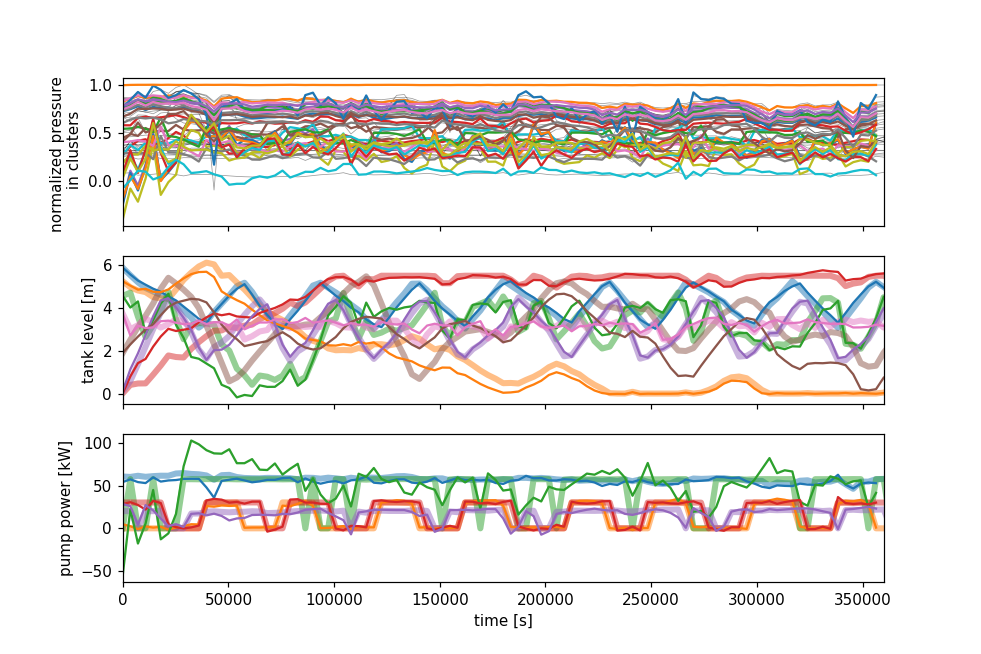

Text(0.5, 0, 'time [s]')

In [129]:
fig, ax = plt.subplots(3,1, sharex=True, figsize=(9,6))

sys_aux_outputs['jun_cl_press_mean'].plot(ax=ax[0], legend=False, linewidth=0.5, color='k', alpha=0.4)
sim_aux['jun_cl_press_mean'].plot(ax=ax[0], legend=False)

sys_states['tank_press'].plot(ax=ax[1], legend=False, alpha=0.5, linewidth=4)
ax[1].set_prop_cycle(None)
sim_res['tank_press'].plot(ax=ax[1], legend=False)

sys_aux_outputs['pump_energy'].plot(ax=ax[2], legend=False, alpha=0.5, linewidth=4)
ax[2].set_prop_cycle(None)
sim_aux['pump_energy'].plot(ax=ax[2], legend=False)

ax[0].set_xlim(0, sim_res.index.max())
ax[0].set_ylabel('normalized pressure \n in clusters')
ax[1].set_ylabel('tank level [m]')
ax[2].set_ylabel('pump power [kW]')
ax[2].set_xlabel('time [s]')

# Linear Model

In [32]:
linear_reg = LinearRegression().fit(nn_input_scaled.to_numpy(), nn_output_scaled.to_numpy())

In [33]:
x0 = sys_states.head(1).to_numpy()
t0 = sys_states.head(1).index.to_numpy()

nsim_lin = simulator(linear_reg, input_scaling, output_scaling, input_offset, output_offset, x0, t0)

In [34]:
for k in range(100):
    print(k)
    sys_inputs_now = sys_inputs.iloc[k].to_numpy()
    nsim_lin.next_step(sys_inputs_now)
sim_res_lin = pd.DataFrame(nsim_lin.x, columns=sys_states.columns, index=nsim_lin.t.flatten())
sim_aux_lin = pd.DataFrame(np.concatenate(nsim_lin.aux), columns = sys_aux_outputs.columns,index=nsim_lin.t.flatten()[:-1])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


<IPython.core.display.Javascript object>


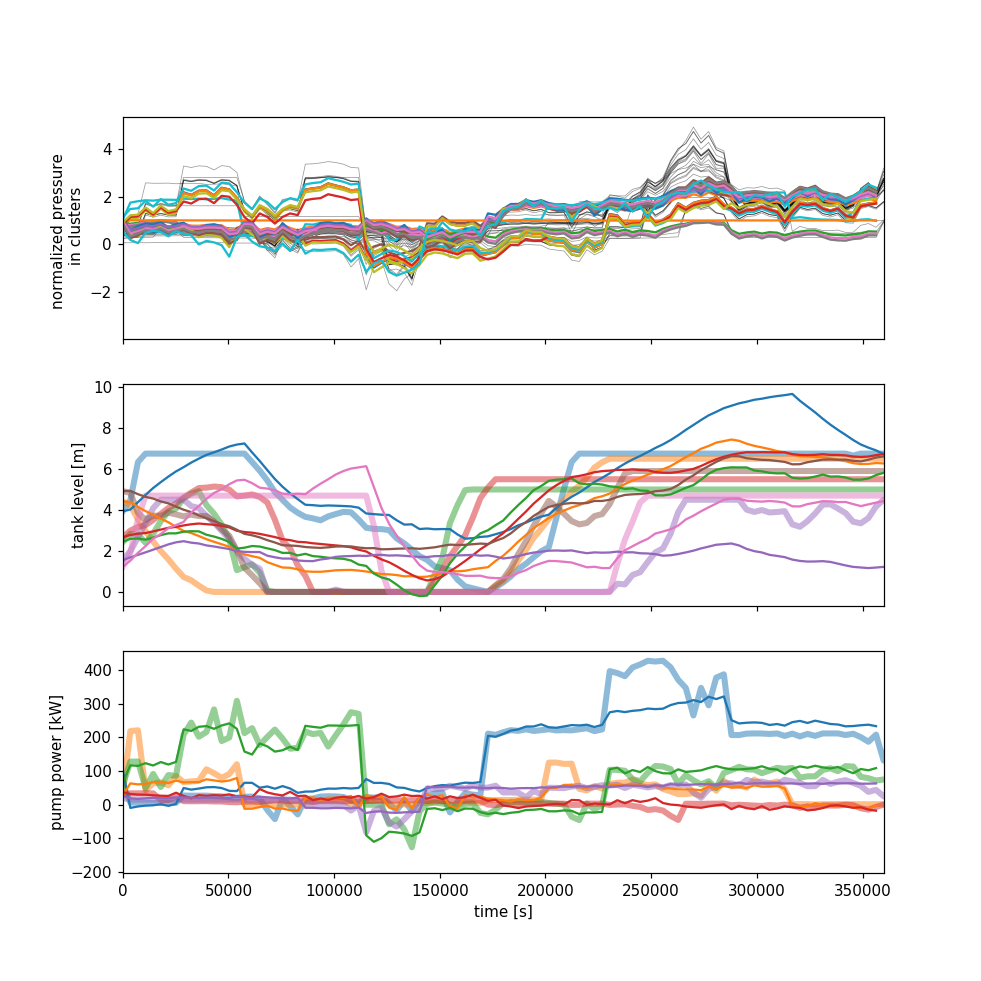

Text(0.5, 0, 'time [s]')

In [35]:
fig, ax = plt.subplots(3,1, sharex=True, figsize=(9,9))

sys_aux_outputs['jun_cl_press_mean'].plot(ax=ax[0], legend=False, linewidth=0.5, color='k', alpha=0.4)
sim_aux_lin['jun_cl_press_mean'].plot(ax=ax[0], legend=False)

sys_states['tank_press'].plot(ax=ax[1], legend=False, alpha=0.5, linewidth=4)
ax[1].set_prop_cycle(None)
sim_res_lin['tank_press'].plot(ax=ax[1], legend=False)

sys_aux_outputs['pump_energy'].plot(ax=ax[2], legend=False, alpha=0.5, linewidth=4)
ax[2].set_prop_cycle(None)
sim_aux_lin['pump_energy'].plot(ax=ax[2], legend=False)

ax[0].set_xlim(0, sim_res_lin.index.max())
ax[0].set_ylabel('normalized pressure \n in clusters')
ax[1].set_ylabel('tank level [m]')
ax[2].set_ylabel('pump power [kW]')
ax[2].set_xlabel('time [s]')